In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3a
commitnumber = 043bdfe
conc = 3.2e-07
dv = 0.01
klin = 2.22e-20
molecule = n2o
ng_adju = [0, 0]
ng_refs = [5, 5]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 620
vmin = 540
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66, 1.66, 1.66, 1.8)]
wgt = [(0.6, 0.6, 0.6, 0.6, 0.6), (0.6, 0.6, 0.6, 0.6, 0.8)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

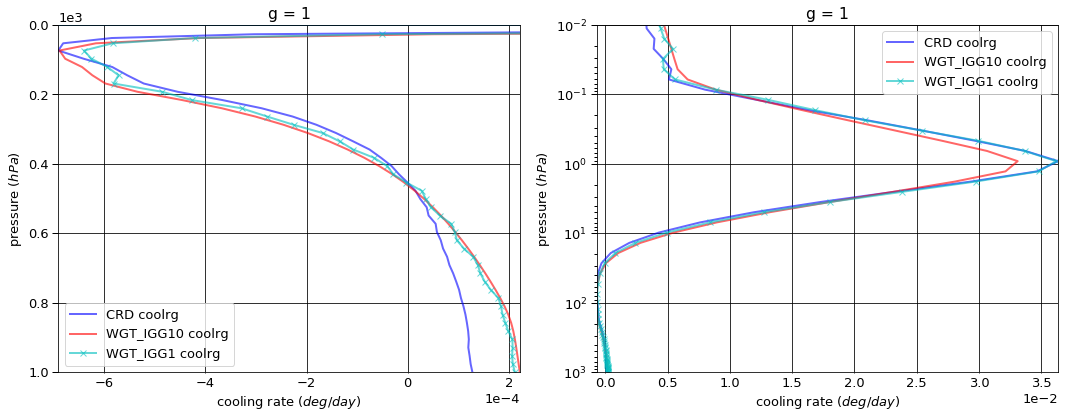

# Figure: cooling rate g-group 2

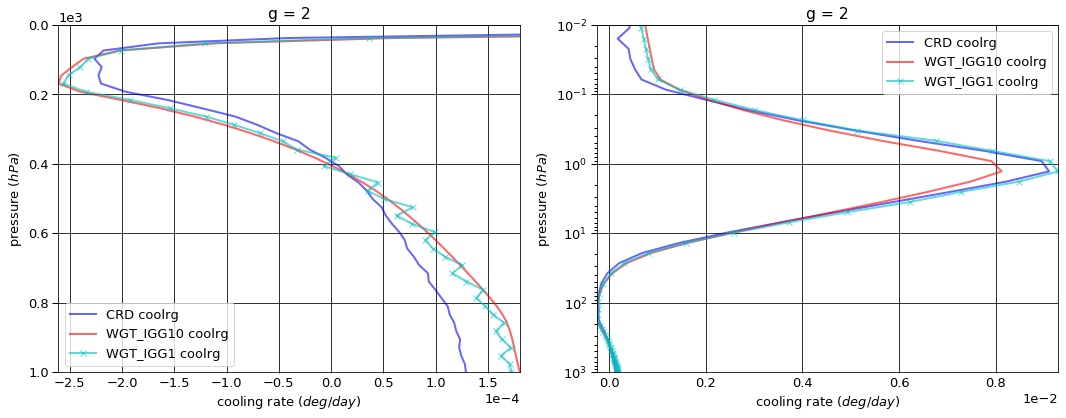

# Figure: cooling rate g-group 3

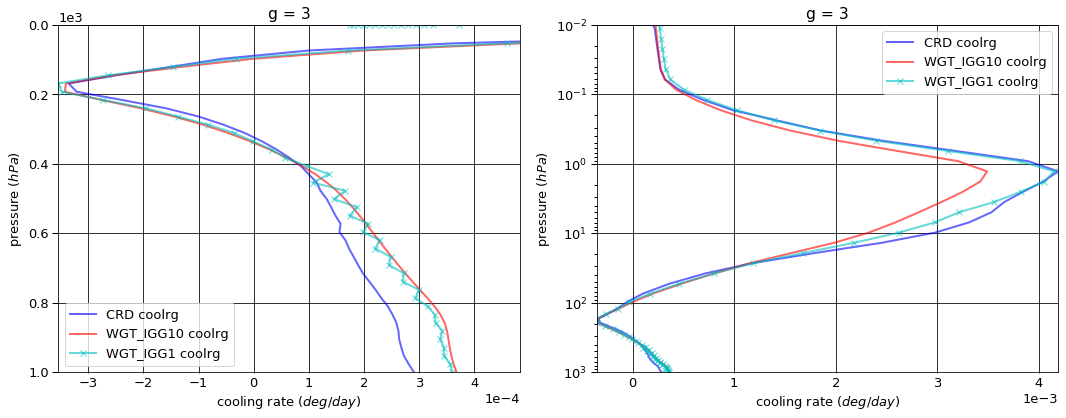

# Figure: cooling rate g-group 4

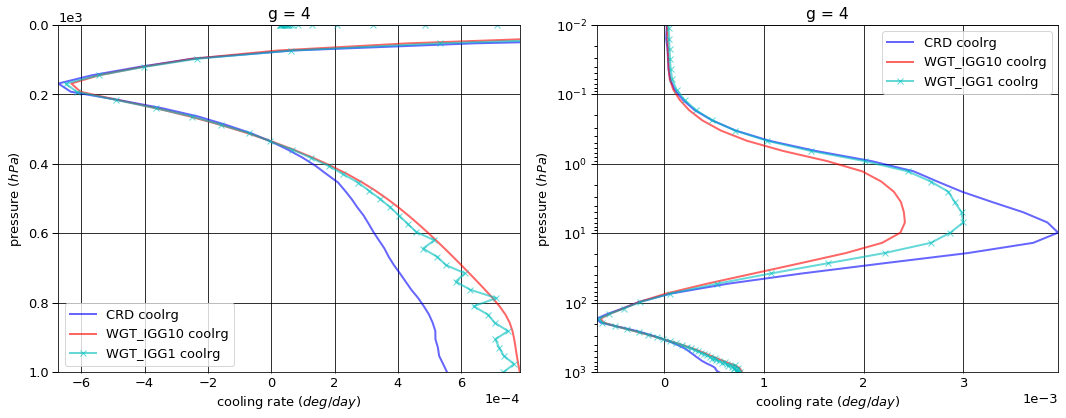

# Figure: cooling rate g-group 5

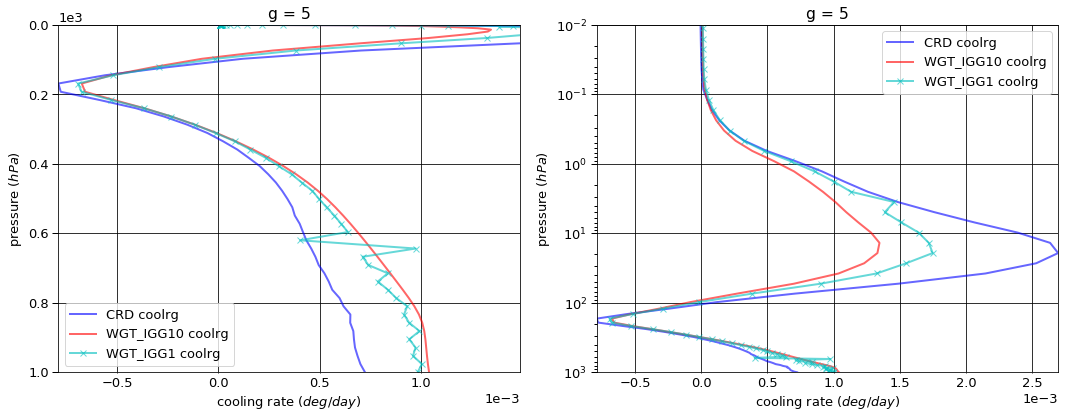

# Figure: cooling rate g-group 6

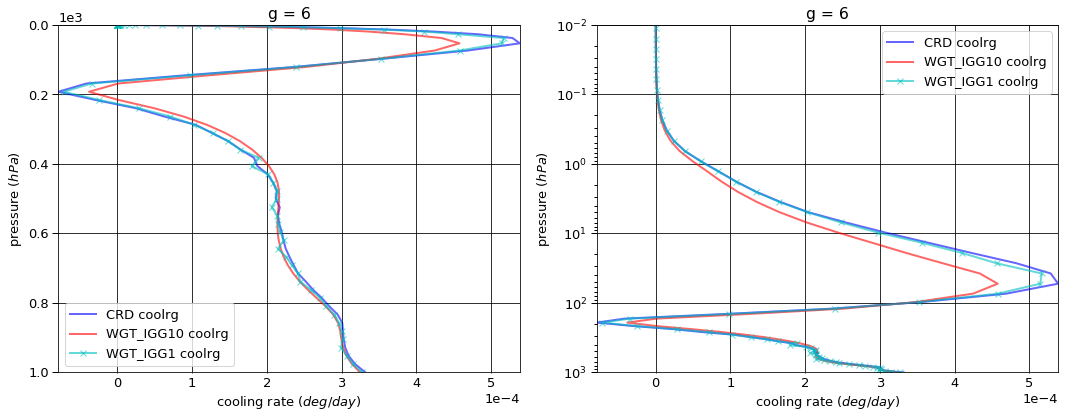

# Figure: cooling rate g-group 7

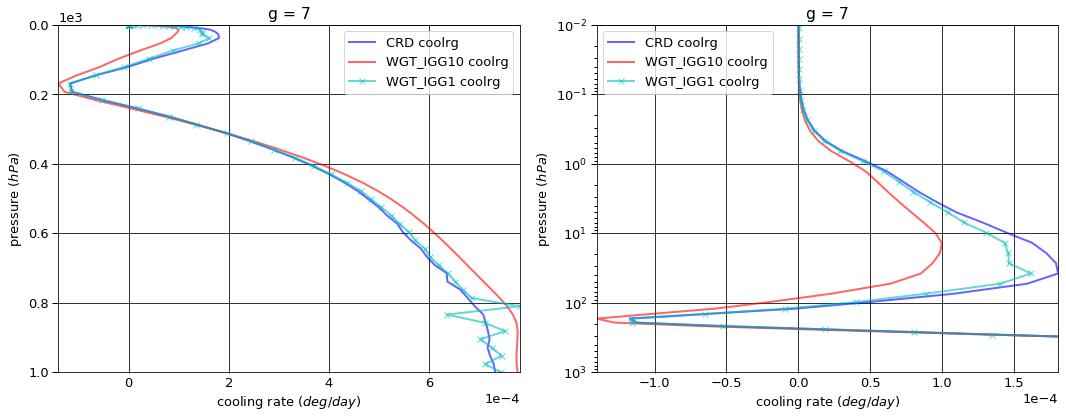

# Figure: cooling rate g-group 8

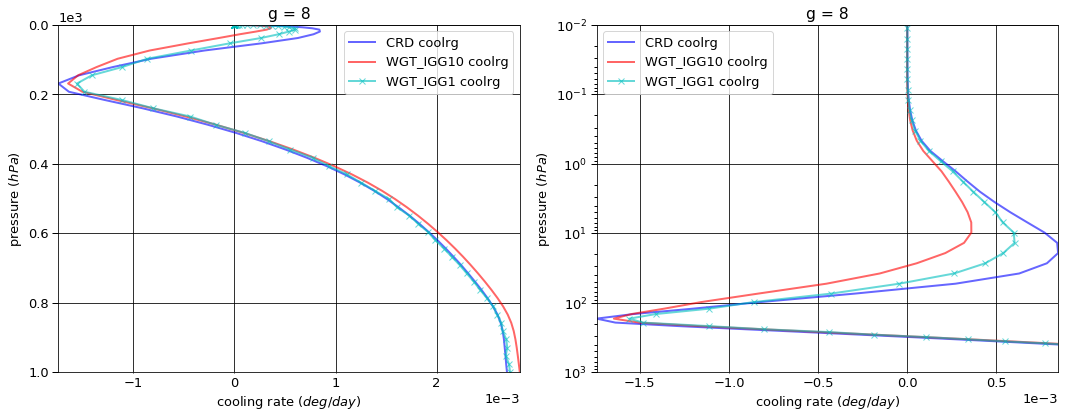

# Figure: cooling rate g-group 9

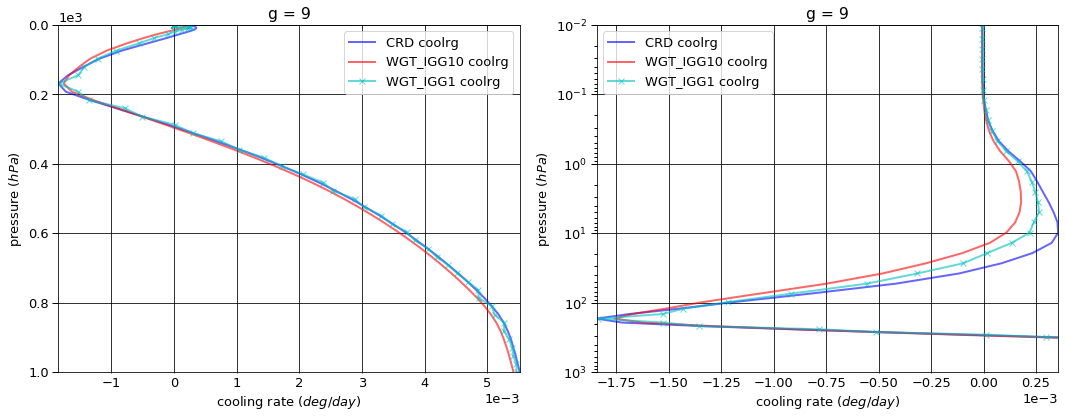

# Figure: cooling rate g-group 10

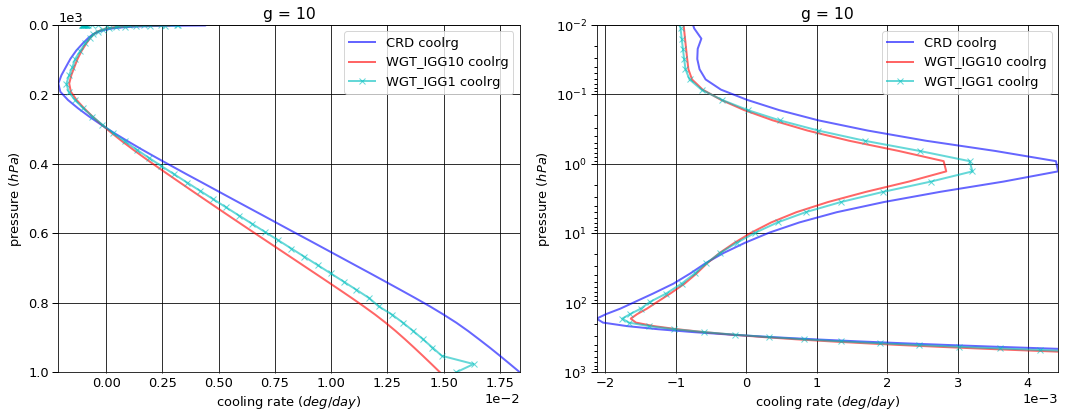

# Figure: cooling rate g-group total

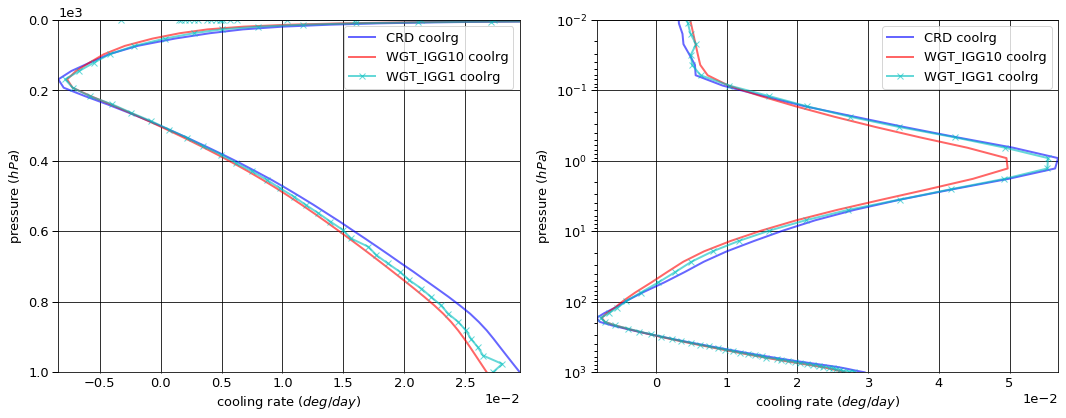

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.037347  0.000000  -0.037347
   1013.0   76     -0.063418  0.034798  -0.028620
2  0.0      1      -0.024683  0.000000  -0.024683
   1013.0   76     -0.040800  0.024250  -0.016551
3  0.0      1      -0.043717  0.000000  -0.043717
   1013.0   76     -0.081634  0.058495  -0.023139
4  0.0      1      -0.102139  0.000000  -0.102139
   1013.0   76     -0.172322  0.103143  -0.069180
5  0.0      1      -0.129791  0.000000  -0.129791
   1013.0   76     -0.226737  0.140998  -0.085739
6  0.0      1      -0.036511  0.000000  -0.036511
   1013.0   76     -0.077111  0.067503  -0.009608
7  0.0      1      -0.088364  0.000000  -0.088364
   1013.0   76     -0.136074  0.096084  -0.039990
8  0.0      1      -0.693347  0.000000  -0.693347
   1013.0   76     -0.910721  0.352549  -0.558173
9  0.0      1      -2.204026  0.000000  -2.204026
   1013.0   76     -2.474260  0.552838  -1.921422
10 0.0      1     -31.655946  0.000000 -31.655946
   1013.0   76    -32.052331  1.184432 -30.867899


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.033665  0.000000  -0.033665
   1013.0   76     -0.063418  0.042468  -0.020951
2  0.0      1      -0.021329  0.000000  -0.021329
   1013.0   76     -0.040800  0.029498  -0.011303
3  0.0      1      -0.038150  0.000000  -0.038150
   1013.0   76     -0.081634  0.067480  -0.014154
4  0.0      1      -0.093351  0.000000  -0.093351
   1013.0   76     -0.172322  0.120380  -0.051943
5  0.0      1      -0.123559  0.000000  -0.123559
   1013.0   76     -0.226737  0.160765  -0.065972
6  0.0      1      -0.034568  0.000000  -0.034568
   1013.0   76     -0.077111  0.069329  -0.007782
7  0.0      1      -0.087266  0.000000  -0.087266
   1013.0   76     -0.136074  0.099754  -0.036320
8  0.0      1      -0.701199  0.000000  -0.701199
   1013.0   76     -0.910721  0.346781  -0.563940
9  0.0      1      -2.231394  0.000000  -2.231394
   1013.0   76     -2.474260  0.513517  -1.960743
10 0.0      1     -31.753959  0.000000 -31.753959
   1013.0   76    -32.052331  0.922625 -31.129706


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.034999  0.000000  -0.034999
   1013.0   76     -0.063418  0.041806  -0.021613
2  0.0      1      -0.022256  0.000000  -0.022256
   1013.0   76     -0.040800  0.028806  -0.011994
3  0.0      1      -0.039780  0.000000  -0.039780
   1013.0   76     -0.081634  0.065862  -0.015772
4  0.0      1      -0.096023  0.000000  -0.096023
   1013.0   76     -0.172322  0.117247  -0.055075
5  0.0      1      -0.126701  0.000000  -0.126701
   1013.0   76     -0.226737  0.156448  -0.070289
6  0.0      1      -0.035734  0.000000  -0.035734
   1013.0   76     -0.077111  0.068028  -0.009083
7  0.0      1      -0.087934  0.000000  -0.087934
   1013.0   76     -0.136074  0.096770  -0.039304
8  0.0      1      -0.696406  0.000000  -0.696406
   1013.0   76     -0.910721  0.350666  -0.560055
9  0.0      1      -2.210769  0.000000  -2.210769
   1013.0   76     -2.474260  0.545803  -1.928457
10 0.0      1     -31.727671  0.000000 -31.727671
   1013.0   76    -32.052331  0.996315 -31.056016


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      3.682691e-03  0.000000  0.003683
   1013.0   76     0.000000e+00  0.007669  0.007669
2  0.0      1      3.353260e-03  0.000000  0.003353
   1013.0   76     0.000000e+00  0.005248  0.005248
3  0.0      1      5.566456e-03  0.000000  0.005566
   1013.0   76     0.000000e+00  0.008985  0.008985
4  0.0      1      8.788203e-03  0.000000  0.008788
   1013.0   76     0.000000e+00  0.017237  0.017237
5  0.0      1      6.231490e-03  0.000000  0.006231
   1013.0   76     0.000000e+00  0.019767  0.019767
6  0.0      1      1.942520e-03  0.000000  0.001943
   1013.0   76     0.000000e+00  0.001826  0.001826
7  0.0      1      1.098446e-03  0.000000  0.001098
   1013.0   76     0.000000e+00  0.003670  0.003670
8  0.0      1     -7.851750e-03  0.000000 -0.007852
   1013.0   76     0.000000e+00 -0.005768 -0.005768
9  0.0      1     -2.736720e-02  0.000000 -0.027367
   1013.0   76    -4.440892e-16 -0.039321 -0.039321
10 0.0      1     -9.801300e-02  0.000000 -0.098013
   1013.0   76     0.000000e+00 -0.261808 -0.261807


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1      2.348764e-03  0.000000  0.002349
   1013.0   76     0.000000e+00  0.007007  0.007007
2  0.0      1      2.426832e-03  0.000000  0.002427
   1013.0   76     0.000000e+00  0.004556  0.004556
3  0.0      1      3.936316e-03  0.000000  0.003936
   1013.0   76     0.000000e+00  0.007367  0.007367
4  0.0      1      6.115687e-03  0.000000  0.006116
   1013.0   76     0.000000e+00  0.014105  0.014105
5  0.0      1      3.089850e-03  0.000000  0.003090
   1013.0   76     0.000000e+00  0.015450  0.015450
6  0.0      1      7.770570e-04  0.000000  0.000777
   1013.0   76     0.000000e+00  0.000525  0.000525
7  0.0      1      4.300810e-04  0.000000  0.000430
   1013.0   76     0.000000e+00  0.000686  0.000686
8  0.0      1     -3.059410e-03  0.000000 -0.003059
   1013.0   76     0.000000e+00 -0.001883 -0.001883
9  0.0      1     -6.742700e-03  0.000000 -0.006743
   1013.0   76    -4.440892e-16 -0.007035 -0.007035
10 0.0      1     -7.172500e-02  0.000000 -0.071725
   1013.0   76     0.000000e+00 -0.188117 -0.188117

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      7.691901e-04
   1001.112500 75     1.278786e-04
2  0.000312    1     -2.733185e-04
   1001.112500 75     1.289077e-04
3  0.000312    1      1.225429e-04
   1001.112500 75     2.906631e-04
4  0.000312    1      6.450339e-06
   1001.112500 75     5.553436e-04
5  0.000312    1     -1.196770e-05
   1001.112500 75     7.243303e-04
6  0.000312    1      3.091883e-08
   1001.112500 75     3.316353e-04
7  0.000312    1      9.848392e-08
   1001.112500 75     7.327478e-04
8  0.000312    1     -2.575884e-07
   1001.112500 75     2.696705e-03
9  0.000312    1     -6.514626e-06
   1001.112500 75     5.517490e-03
10 0.000312    1     -8.984076e-04
   1001.112500 75     1.838844e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.700134e-03
   1001.112500 75     2.216185e-04
2  0.000312    1      4.464088e-04
   1001.112500 75     1.804366e-04
3  0.000312    1      1.516655e-04
   1001.112500 75     3.676653e-04
4  0.000312    1      1.567784e-05
   1001.112500 75     7.849350e-04
5  0.000312    1      3.848560e-06
   1001.112500 75     1.040994e-03
6  0.000312    1      2.546235e-08
   1001.112500 75     3.246809e-04
7  0.000312    1     -3.838368e-08
   1001.112500 75     7.772554e-04
8  0.000312    1     -7.118102e-07
   1001.112500 75     2.823638e-03
9  0.000312    1     -7.209544e-06
   1001.112500 75     5.416936e-03
10 0.000312    1     -9.961043e-04
   1001.112500 75     1.483926e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      2.038055e-03
   1001.112500 75     2.116932e-04
2  0.000312    1      3.016396e-04
   1001.112500 75     1.724442e-04
3  0.000312    1      1.751083e-04
   1001.112500 75     3.596580e-04
4  0.000312    1      2.662566e-05
   1001.112500 75     7.327733e-04
5  0.000312    1      6.515509e-06
   1001.112500 75     9.845444e-04
6  0.000312    1      3.362067e-08
   1001.112500 75     3.272033e-04
7  0.000312    1      2.671026e-08
   1001.112500 75     7.440856e-04
8  0.000312    1     -4.102465e-07
   1001.112500 75     2.727144e-03
9  0.000312    1     -6.321175e-06
   1001.112500 75     5.464462e-03
10 0.000312    1     -1.058654e-03
   1001.112500 75     1.556111e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.930943e-03
   1001.112500 75     9.373987e-05
2  0.000312    1      7.197273e-04
   1001.112500 75     5.152886e-05
3  0.000312    1      2.912260e-05
   1001.112500 75     7.700219e-05
4  0.000312    1      9.227503e-06
   1001.112500 75     2.295915e-04
5  0.000312    1      1.581626e-05
   1001.112500 75     3.166641e-04
6  0.000312    1     -5.456485e-09
   1001.112500 75    -6.954350e-06
7  0.000312    1     -1.368676e-07
   1001.112500 75     4.450759e-05
8  0.000312    1     -4.542218e-07
   1001.112500 75     1.269326e-04
9  0.000312    1     -6.949178e-07
   1001.112500 75    -1.005542e-04
10 0.000312    1     -9.769669e-05
   1001.112500 75    -3.549185e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.268865e-03
   1001.112500 75     8.381455e-05
2  0.000312    1      5.749581e-04
   1001.112500 75     4.353654e-05
3  0.000312    1      5.256534e-05
   1001.112500 75     6.899486e-05
4  0.000312    1      2.017533e-05
   1001.112500 75     1.774297e-04
5  0.000312    1      1.848320e-05
   1001.112500 75     2.602141e-04
6  0.000312    1      2.701834e-09
   1001.112500 75    -4.431990e-06
7  0.000312    1     -7.177366e-08
   1001.112500 75     1.133783e-05
8  0.000312    1     -1.526581e-07
   1001.112500 75     3.043880e-05
9  0.000312    1      1.934513e-07
   1001.112500 75    -5.302790e-05
10 0.000312    1     -1.602469e-04
   1001.112500 75    -2.827332e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.015871,0.000000,-35.015871
1013.0,76,-36.235408,2.615089,-33.620319



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.118440,0.000000,-35.118440
1013.0,76,-36.235408,2.372595,-33.862813



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.078273,0.000000,-35.078273
1013.0,76,-36.235408,2.467751,-33.767658



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.102569,0.000000,-0.102569
1013.0,76,0.000000,-0.242494,-0.242494



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.062403,0.000000,-0.062403
1013.0,76,0.000000,-0.147339,-0.147339


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000292
1001.112500,75,0.029494



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002314
1001.112500,75,0.026777



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.001483
1001.112500,75,0.027285



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002606
1001.112500,75,-0.002717



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001775
1001.112500,75,-0.002209


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001750,0.001730
2,0.001125,0.001119
3,0.002250,0.002237
4,0.004750,0.004726
5,0.006250,0.006216
6,0.002125,0.002113
7,0.003750,0.003728
8,0.025125,0.024840
9,0.068250,0.067714


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.106522e-18
2,7.728049e-19
3,1.922495e-19
4,4.782564e-20
5,1.189751e-20
6,3.294470e-19
7,1.341762e-19
8,5.464686e-20
9,2.225641e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.106522e-18,NaN,0.001750,0.001730,0.001750,0.001730,1.0
2,7.728049e-19,0.248769,0.001125,0.001119,0.002875,0.002848,1.0
3,1.922495e-19,0.248769,0.002250,0.002237,0.005125,0.005085,1.0
4,4.782564e-20,0.248769,0.004750,0.004726,0.009875,0.009811,1.0
5,1.189751e-20,0.248769,0.006250,0.006216,0.016125,0.016028,1.0
6,3.294470e-19,27.690406,0.002125,0.002113,0.018250,0.018141,500.0
7,1.341762e-19,0.407277,0.003750,0.003728,0.022000,0.021869,500.0
8,5.464686e-20,0.407277,0.025125,0.024840,0.047125,0.046709,500.0
9,2.225641e-20,0.407277,0.068250,0.067714,0.115375,0.114423,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
